In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

Standard activation functions

In [2]:
def sigmoid(x):
    return 1/(1+np.exp((-x)))

def RELU(x):
  return max(0,x)

def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def PRelu(x, alpha=0.01):
  return max(alpha*x, x)

def softmax(input: np.ndarray):
  
  x = input.copy()
  
  for i in range(x.size):
    x[i] = np.exp(x[i])

  sum = np.sum(x)
  for i in range(x.size):
    x[i] /= sum

  return x
  
ACTIVATIONS = {"sigmoid", "relu", "tanh", "prelu"}

Opening the CIFAR-10 Dataset

In [3]:
LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]									
							
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

ips = np.zeros((50000, 3072), dtype= np.uint8)
labels = np.zeros(50000, dtype=np.uint8)

for i in range(1,6):
    # Place the dataset in appropriate location
    file = "cifar-10-python/cifar-10-batches-py/data_batch_" + str(i)
    dict = unpickle(file)
    labl = np.array(dict[b'labels'], dtype= np.uint8)
    inp = np.array(dict[b'data'], dtype= np.uint8)
    ips[ (i-1)*10000: i*10000, :] = inp
    labels[(i-1)*10000: i*10000] = labl


inputs = np.zeros((50000, 32, 32, 3))
for i in range(50000):
    inputs[i, : ,:, 0] = ips[i, 0:1024].reshape(32,32)
    inputs[i, : ,:, 1] = ips[i, 1024:2048].reshape(32,32)
    inputs[i, : ,:, 2] = ips[i, 2048:3072].reshape(32,32)

inputs/= 255
print(inputs.shape)
print(labels.shape)


(50000, 32, 32, 3)
(50000,)


# Question 1
Convolution function definition

In [4]:
def conv2d_function(image: np.ndarray, kernel: np.ndarray, bias : int = 0
                    , stride : int = 1, padding : int = 0, activation : str = "Sigmoid"):

    """ The convolution function accepts an image as input and returns the output activations as numpy array
    
    Arguments : 
    -

    image - numpy array with (H,W,C) dimension, input image

    kernel -numpy array with (h,w,C) dimension, weights in convolution

    bias - integer, represents the bias in convolution, default = 0

    stride - integer,  Defines the stride (s,s) to be used in the convolution, default = 1

    padding - integer, represents the padding to be used in the input array, default = 0

    activation - string, Used to define the activation function to be used while output, options are
                sigmoid, ReLU, tanh, PReLu, default = Sigmoid

    Returns an output convolved numpy array with dimensions as ((H - h + 2*padding )/stride + 1, (W - w + 2*padding )/stride + 1)
     """
    assert(activation.lower() in ACTIVATIONS)
    H, W, C = image.shape
    h, w, C = kernel.shape

    op_H = (H - h + 2*padding )/stride + 1
    op_W = (W - w + 2*padding )/stride + 1

    output = np.zeros((int(op_H), int(op_W)))
    if padding == 0:
        input = image
        H_ = H
        W_ = W
    else:

        input = np.zeros((H+ 2*padding, W+ 2*padding, C))
        input[padding : H+ 1*padding, padding : W+ 1*padding, :] = image
        H_ = H+ 2*padding
        W_ = W+ 2*padding

   # Actcual convolution operation
    i = j = 0
    for x in range(0, H_, stride):
        for y in range(0, W_, stride):
            if(y + w > W_ or x + h > H_):
                break
            else:
                wsum = np.sum(np.multiply(input[x:x+h, y:y+h, :],  kernel))
                output[i][j] = wsum + bias
            j+=1
        i +=1
        j = 0
        

    if activation.lower() =="sigmoid":
        output = sigmoid(output)
    elif activation.lower() =="tanh":
        output = tanh(output)
    elif activation.lower() =="relu":
        output = RELU(output)
    elif activation.lower() =="prelu":
        output = PRelu(output)

    return output

Opening image of iith_logo RGB image of (32, 32)

(32, 32, 3)
Low Resolution image of IITH logo: 


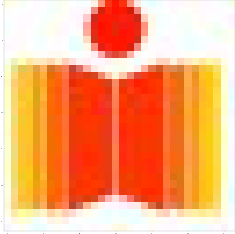

In [5]:
iith_img = plt.imread("iith_logo.jpg")
print(iith_img.shape)
iith_img = (iith_img)/255
print("Low Resolution image of IITH logo: ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(iith_img)
plt.show()


Defining kernel of size (3,3,3) from  standard normal distribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Kernel used in Convolution:


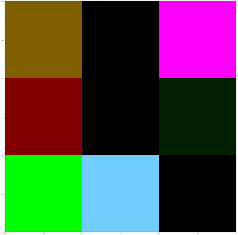

In [6]:
kernel = np.random.randn(27).reshape(3,3,3)
print("Kernel used in Convolution:")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(kernel)
plt.show()

Calling the convolution function and displaying the output image with dimensions (32,32,3) , kernel with dimensions (3,3,3) , bias = 0 , stride =1 , padding =0 and sigmoid activation function

Output activation image : 


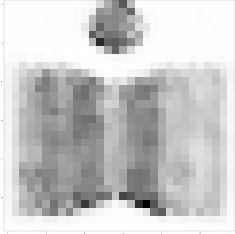

In [7]:
output_act = conv2d_function(iith_img , kernel)

print("Output activation image : ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(output_act, cmap= "Greys")
plt.show()

# Question 2
The pooling function section

In [8]:
POOL_FUNCTIONS = {"max", "avg"}
def pool_function(input : np.ndarray, kernel_size: tuple, pooling_func : str = "Max", stride: int = 2):
    """ The pooling function accepts an image as input and returns the output activations as numpy array
    
    Arguments : 
    -

    input - numpy array with (H,W) dimension, input will be activation output from previous layer

    kernel_size -tuple indicating dimension of kernels

    pooling_func - The function or type of pooling (max, avg) , default = max

    stride - (s,s) stride value to be chosen while performing the pooling operation, default = 2
    
    Returns an output pooled numpy array with dimensions as ((H - h )/stride + 1, (W - w )/stride + 1 )

     """
    assert(pooling_func.lower() in POOL_FUNCTIONS)
    H ,W = input.shape
    h, w = kernel_size
    
    op_H = (H - h )/stride + 1
    op_W = (W - w )/stride + 1

    output = np.zeros((int(op_H), int(op_W)))

    # Actcual pooling operation
    i = j = 0
    for x in range(0, H, stride):
        for y in range(0, W, stride):
            if(y + w > W or x + h > H):
                break
            else:
                wsum = 0
                if pooling_func.lower() == "max":
                    wsum = np.amax(input[x:x+h, y:y+h])
                elif pooling_func.lower() == "avg":
                    wsum = np.average(input[x:x+h, y:y+h])

                output[i][j] = wsum 
            j+=1
        i +=1
        j = 0

    return output

Displaying the input activation map and calling the pooling function

Input activation image: 


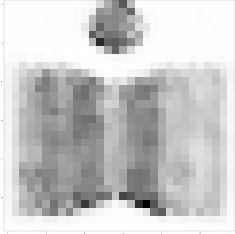

In [9]:
input_act = output_act
print("Input activation image: ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(input_act , cmap= "Greys")
plt.show()

# Used (2,2) kernel and stride =2 with max pooling
pooled_out = pool_function(input_act, (2,2))

Displaying the pooled output map

Pooled output:  


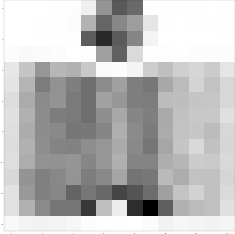

In [10]:
print("Pooled output:  ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(pooled_out, cmap= "Greys")
plt.show()

# Question 3
Convolution layer function

In [11]:
def conv2d_layer(input: np.ndarray, num_filters : int , kernels: np.ndarray, bias = None
                , stride : int = 1, padding : int = 0, activation : str = "Sigmoid"):
    """ The convolution layer accepts an image or activation maps as input and returns 
    the convolved output activations with num_filters kernels as numpy array.
    
    Arguments:
    -
        input: numpy array with (H,W,C) dimension, input to the convolution function

        num_filters: integer, specifies the number of kernels to be used - D

        kernels: numpy array with (h, w, C, D) dimension, weights in convolution used

        bias: numpy array of d-dimensions, represents the bias in convolution, default = None

        stride: integer,  Defines the stride (s,s) to be used in the convolution, default = 1

        padding: integer, represents the padding to be used in the input array, default = 0

        activation: string, Used to define the activation function to be used while output, options are
                    sigmoid, ReLU, tanh, PReLu, default = Sigmoid

    Returns an output convolved numpy array with dimensions as ((H - h + 2*padding )/stride + 1, (W - w + 2*padding )/stride + 1 , D)
    """
    assert(activation.lower() in ACTIVATIONS)
    H, W, C = input.shape
    h, w, C, D = kernels.shape

    op_H = (H - h + 2*padding )/stride + 1
    op_W = (W - w + 2*padding )/stride + 1

    output = np.zeros((int(op_H), int(op_W), D))
    
    for i in range(num_filters):
        if bias==None:
            output[:, :, i] = conv2d_function(input, kernels[:, :, :, i], 0, stride, padding, activation)
        else:
            output[:, :, i] = conv2d_function(input, kernels[:, :, :, i], bias[i], stride, padding, activation)

    return output

Displaying the Input image

Input Image of deer 


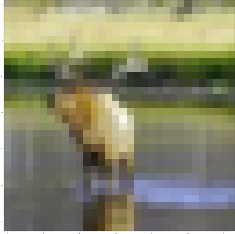

In [12]:
i = rng.integers(low=0, high=50000, size=1)
input_img = inputs[i[0]]
print(f"Input Image of {LABELS[labels[i].item()]} ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(input_img)
plt.show()

Displaying 5 different kernel filters used for convolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


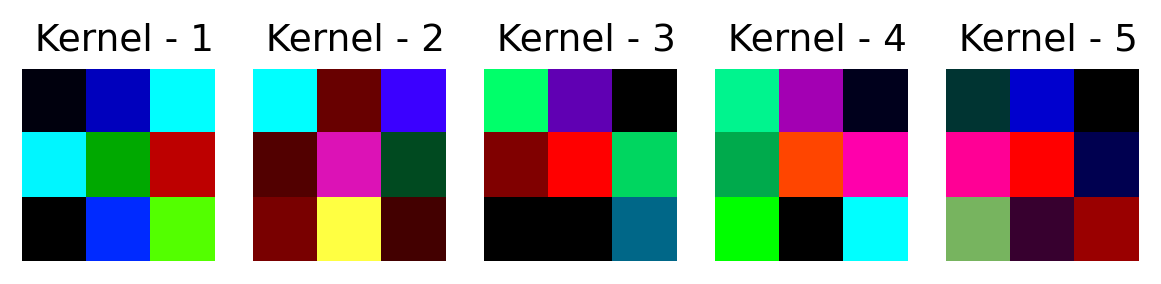

In [13]:
num_kernels = 5
kernels = np.random.randn(27*num_kernels).reshape(3,3, 3, num_kernels)

f, axarr = plt.subplots(1,num_kernels)
f.dpi = 225
for i in range(num_kernels):
    axarr[i].set_title(" Kernel - "+ str(i+1))
    axarr[i].axis("off")
    axarr[i].imshow(kernels[:, :, :, i])

plt.show()
# for i in range(num_kernels):
#     print(f"Kernel - {i+1}: ")
#     plt.figure(figsize=(30, 30), dpi=10)
#     plt.imshow(kernels[:, :, :, i])
#     plt.show()

Calling the convolutional layer function and displaying the 5 outputs generated from the convolution layer

Verifying the expected shape = (30, 30, 5)



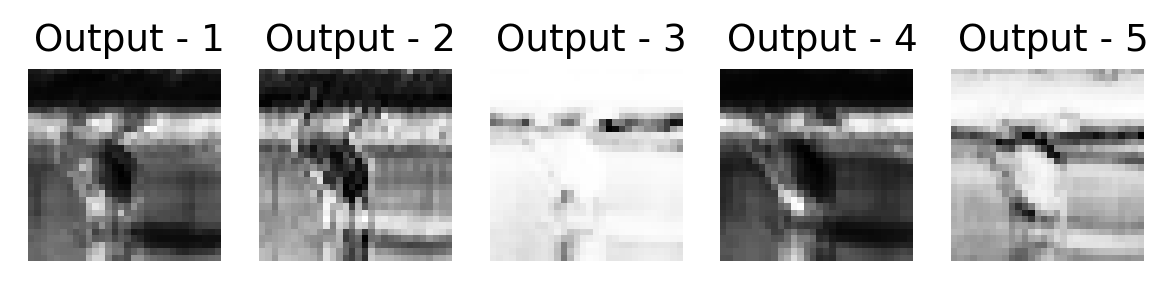

In [14]:
# Input - (32,32,3) , kernel filters with dimensions (3,3,3,5) , bias = None , stride =1 , padding =0 and sigmoid activation function
act_outs = conv2d_layer(input_img, num_kernels, kernels)

print(f"Verifying the expected shape = {act_outs.shape}\n")   

f, axarr = plt.subplots(1, num_kernels)
f.dpi = 225
for i in range(num_kernels):
    axarr[i].set_title(" Output - "+ str(i+1))
    axarr[i].axis("off")
    axarr[i].imshow(act_outs[:, :, i], cmap="Greys")

plt.show()

# Question 4
Pooling layer function

In [15]:
POOL_FUNCTIONS.add("gap")
def pool_layer(input : np.ndarray, kernel_size: tuple = (2,2), pooling_func : str = "Max", stride: int = 2):
    """ The pooling layer function accepts an image or activation volume as input and returns the output activations volume as numpy array
    
    Arguments : 
    -

    input - numpy array with (H,W,C) dimension, input will be activation output from previous layer

    kernel_size -tuple indicating dimension of kernels,(k,k), deafult= (2,2)

    pooling_func - The function or type of pooling (max, avg, gap), A special case for global average pooling is also provided , default = max

    stride - (s,s) stride value to be chosen while performing the pooling operation, default = 2
    
    Returns an output pooled numpy array with dimensions as ((H - h )/stride + 1, (W - w )/stride + 1, C)

     """
    assert(pooling_func.lower() in POOL_FUNCTIONS)
    H ,W ,C = input.shape
    if pooling_func.lower() == "gap":
        output = np.zeros((1,1,C))
        for i in range(C):
            output[:, :, i] = np.average(input[:,:,i])

    else:
        
        h, w = kernel_size
        op_H = (H - h )/stride + 1
        op_W = (W - w )/stride + 1

        output = np.zeros((int(op_H), int(op_W), C))

        # Actcual pooling layer operation
        for i in range(C):
            output[:, :, i] = pool_function(input[:, :, i], kernel_size, pooling_func, stride)

    return output

Displaying the input volume, the output from the convoluted layer

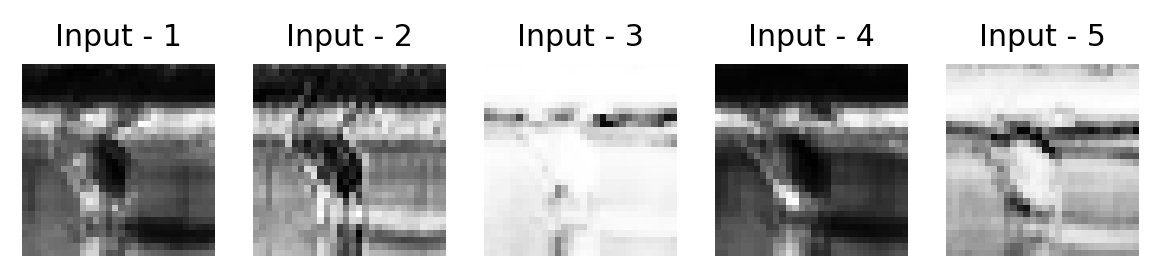

In [16]:
input_vol = act_outs
f, axarr = plt.subplots(1, num_kernels)
plt.rcParams.update({'font.size': 8})
f.dpi = 225
for i in range(num_kernels):
    axarr[i].set_title("Input - "+ str(i+1))
    axarr[i].axis("off")
    axarr[i].imshow(input_vol[:, :, i], cmap="Greys")

plt.show()

Calling the pooling layer function with (2,2) kernel and stride = 2 with max pooling and displaying the outputs produced.<br />
Also included the Global Average pooling Case 

(15, 15, 5)


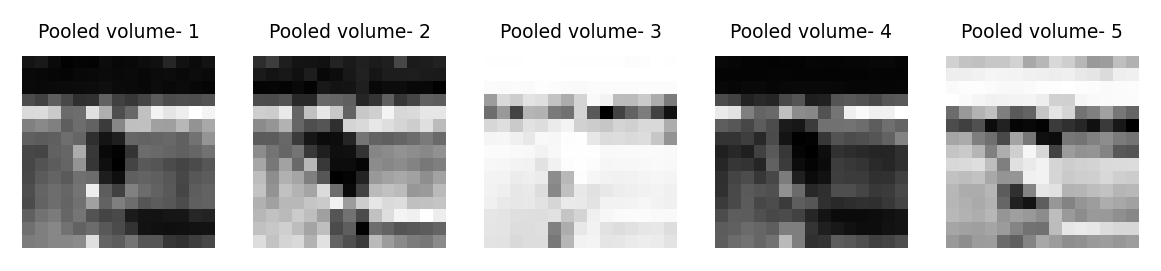

The output from GAP is [[[0.88980938 0.72611056 0.0300076  0.93151063 0.20989332]]] with shape = (1, 1, 5)


In [17]:
out_vol = pool_layer(input_vol, (2,2),"Max", 2)
print(out_vol.shape)
f, axarr = plt.subplots(1, num_kernels)
plt.rcParams.update({'font.size': 5})
f.dpi = 225

for i in range(num_kernels):
    axarr[i].set_title("Pooled volume- "+ str(i+1))
    axarr[i].axis("off")
    axarr[i].imshow(out_vol[:, :, i], cmap="Greys")

plt.show()

out_vec= pool_layer(input_vol, (2,2),"GAP", 2)
print(f"The output from GAP is {out_vec} with shape = {out_vec.shape}")


# Question 5
Flattening the pooled output from previous layers and converting it into a vector

In [18]:
def flatten_input(input: np.ndarray, size: int = None, weights: np.ndarray = None):
     """ The flattening function accepts input as a 3d matrix and outputs a vector of size - size
    
    Arguments : 
    -

    input - numpy array with (H,W,C) dimension, input will be pooled output from previous layer

    size - integer indicating dimension of the output vector, default = None

    weights - numpy array with dimensions ( size, H*W*C), used to output vector of appropriate dimensions, default = None
    
    Returns an output vector (numpy array) with dimension as size

     """
     H,W,C = input.shape
     ip = np.zeros((H*W*C, 1))

     i= 0
     for h in range(H):
          for w in range(W):
               ip[i * C : (i+1) * C, 0] = input[h, w, :]
               i+=1
     if size == None or size == ip.size:
          return ip

     if weights==None:
          weights = np.random.randn(size*H*W*C).reshape((size, H*W*C))
    
     output =  weights @ ip
     return output


flat_vec= flatten_input(out_vol, 1000)
print(flat_vec.shape)

(1000, 1)


# Question 6
Multilayer perceptron is defined here

In [19]:
def MLP(input: np.ndarray, num_hidden_layers: int, hidden_dims: np.ndarray, activation: str , out_size: int, 
        weights: list = None, bias: list = None):
    """ The MLP function represents a multi-layer perceptron layer or fully connected layer. It accepts input vector 
        and it generates the output with and without the softmax function applied to the output layer.
    
    Arguments : 
    -

    input - numpy vector with (N,1) dimension, input will be flattened output from previous layer

    num_hidden_layers - integer indicating number of hidden layers of the MLP

    hidden_dims - numpy array with of size as number of hidden layers, with each entry representing the number of neurons in that hidden layer

    activation - string, Used to define the activation function to be used in the MLP, options are
                sigmoid, ReLU, tanh, PReLu, default = Sigmoid

    out_size- integer, represents the output size  of the MLP (or no. of neurons in output layer)

    weights - list indicating the weight matrices of each layer to be used, default = None

    bias - list indicating the bias matrices of each layer, default = None
    
    Returns a tuple of the output with and without the softmax function applied to the output layer.

     """
    assert(activation.lower() in ACTIVATIONS)

    # A numpy array to represent all dimensions of each layer

    dims = np.zeros(2+num_hidden_layers, dtype =int)
    num_layers = dims.size
    dims[0] = input.size
    dims[num_layers-1] = out_size
    dims[1:num_layers-1] =  hidden_dims

    if weights == None:
        weights = []
        bias = []
        for i in range(num_layers-1):
            W = np.random.randn( dims[i+1] * dims[i]).reshape((dims[i+1], dims[i]))
            weights.append(W)
            b = np.random.randn(dims[i+1]).reshape((dims[i+1],1))
            bias.append(b)
    
    if bias == None:
        bias = []
        for i in range( num_hidden_layers+1):
            b = np.zeros((dims[i+1],1))
            bias.append(b)

    output = np.zeros(out_size)
    prev_out =  input

    for layer in range(num_layers-1):
        s = weights[layer] @ prev_out + bias[layer]
        if layer == num_layers-2:
            output = s
            break

        if activation.lower() =="sigmoid":
            prev_out = sigmoid(s)
        elif activation.lower() =="tanh":
            prev_out = tanh(s)
        elif activation.lower() =="relu":
            prev_out = RELU(s)
        elif activation.lower() =="prelu":
            prev_out = PRelu(s)

    
    return (softmax(output), output)
    
    
n = 2
hd = np.array([10, 20], dtype = int)
out = 10

MLP(flat_vec, n, hd, "Sigmoid", out)

(array([[5.35871443e-04],
        [8.97092015e-05],
        [1.30335004e-05],
        [9.96934882e-01],
        [4.84420267e-04],
        [5.76525634e-06],
        [1.18922122e-03],
        [6.91975913e-04],
        [2.32307944e-05],
        [3.18907401e-05]]),
 array([[-0.70855465],
        [-2.4958756 ],
        [-4.42492594],
        [ 6.81999179],
        [-0.80949609],
        [-5.24059932],
        [ 0.08860499],
        [-0.45289779],
        [-3.8469702 ],
        [-3.53013325]]))

# Question 7
Implementing the CNN

In [20]:
class CNN:

    def __init__(self):

        # Intializing random kernels for 1st layer
        self.kernels1 = np.random.randn( 3*3*3*16).reshape((3,3,3,16))

        # Intializing random kernels for 2nd layer
        self.kernels2 = np.random.randn( 3*3*16*8).reshape((3,3,16,8))

        # Intitalizing weights and bias for MLP 8 inputs, 8 hidden layers, 10 output layers
        self.weights = []
        self.bias = []

        w = np.random.randn(8*8).reshape((8,8))
        self.weights.append(w)
        w = np.random.randn(10*8).reshape((10, 8))
        self.weights.append(w)

        b = np.random.randn(8).reshape((8,1))
        self.bias.append(b)
        b = np.random.randn(10).reshape((10, 1))
        self.bias.append(b)

        

    def feed_forward(self, input: np.ndarray, num_outputs: int):

        """ The feed forward function implements the CNN's feed forward path, meaning given an input image it will 
            output a vector of dimensions the same as no. of output classes
        
        Arguments : 
        -

        input - numpy image with (H,W,C) dimensions, input will be the image from dataset

        num_outputs - integer, indicating the number of output classes

        Returns a numpy array representing a vector of dimension the same as output no. of classes.

        """

        # Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.
        first_conv_output = conv2d_layer(input= input, num_filters= 16, kernels= self.kernels1, activation= "Sigmoid") 

        # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
        first_pool_output = pool_layer(input= first_conv_output, kernel_size= (2,2), pooling_func= "Max", stride= 2)

        # Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.
        second_conv_output = conv2d_layer(input= first_pool_output, num_filters= 8, kernels= self.kernels2, activation= "Sigmoid") 

        # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
        second_pool_output = pool_layer(input= second_conv_output, kernel_size= (2,2), pooling_func= "Max", stride= 2)

        # A Global Average Pooling (GAP) layer.
        gap_output = pool_layer(input= second_pool_output, pooling_func= "GAP")

        # Flattening or reshaping GAP output
        flat_vector = flatten_input(input= gap_output)

        # An MLP with one hidden layer
        hd_dim = np.array(flat_vector.size)
        output_vec_softmax, output_vec = MLP(input= flat_vector, num_hidden_layers= 1, hidden_dims= hd_dim, activation= "Sigmoid"
                                            , out_size= num_outputs, weights= self.weights, bias= self.bias)

        return output_vec_softmax, flat_vector

Calling the feedforward function

In [21]:
# Crteating once so that the weights do not get reintialized
cnn = CNN()

Input Image of frog 


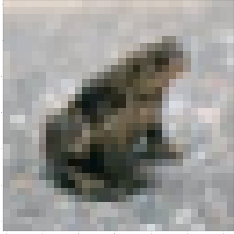

(10, 1)
[[2.99280663e-03]
 [1.39444342e-02]
 [2.09981420e-03]
 [5.94811237e-03]
 [1.08659421e-01]
 [2.57118479e-04]
 [8.43510525e-01]
 [1.70742851e-02]
 [5.41209038e-03]
 [1.01392707e-04]]


In [22]:
i = rng.integers(low=0, high=50000, size=1)

input = inputs[i[0]]
print(f"Input Image of {LABELS[labels[i].item()]} ")
plt.figure(figsize=(30, 30), dpi=10)
plt.imshow(input)
plt.show()


output, fv = cnn.feed_forward(input= input, num_outputs= 10)
print(output.shape)
print(output)

# Question 8


In [23]:
class_wise_labels = np.zeros((10, 5000), dtype= int)
for i in range(10):
    b= np.where( labels == i)
    class_wise_labels[i, :] =  b[0]

ind = rng.integers(low=0, high=5000, size=1)

for c in range(10):

    i = class_wise_labels[c, ind[0]]
    input = inputs[i]
    output,fv = cnn.feed_forward(input= input, num_outputs= 10)
    print("\nOutput vector for label : ", LABELS[labels[i]])
    print(output)
    



Output vector for label :  airplane
[[3.00858027e-03]
 [1.35790209e-02]
 [2.07466557e-03]
 [5.77445415e-03]
 [1.10256146e-01]
 [2.57110395e-04]
 [8.42258678e-01]
 [1.71476811e-02]
 [5.53882961e-03]
 [1.04833493e-04]]

Output vector for label :  automobile
[[2.96935935e-03]
 [1.48687074e-02]
 [2.14372353e-03]
 [6.37825445e-03]
 [1.05117919e-01]
 [2.58733612e-04]
 [8.46182134e-01]
 [1.68633652e-02]
 [5.12365623e-03]
 [9.41467858e-05]]

Output vector for label :  bird
[[2.98392803e-03]
 [1.41537690e-02]
 [2.10893136e-03]
 [6.03229360e-03]
 [1.08301162e-01]
 [2.56810791e-04]
 [8.43591069e-01]
 [1.71089604e-02]
 [5.36320149e-03]
 [9.98735404e-05]]

Output vector for label :  cat
[[2.89368661e-03]
 [1.57677210e-02]
 [2.16880147e-03]
 [6.73518839e-03]
 [1.02910192e-01]
 [2.53912699e-04]
 [8.47533831e-01]
 [1.68804909e-02]
 [4.76882511e-03]
 [8.73506699e-05]]

Output vector for label :  deer
[[2.90444984e-03]
 [1.73754554e-02]
 [2.18404447e-03]
 [7.16054862e-03]
 [1.06927601e-01]
 [2.57295736

Observations from 8a) Irrespective of the input images the CNN outputs similar output vectors depending upon the initializations. The output vectors are predicting the same thing irrespective of theinput images.

Question 8 b) Visualize (plot) the bottleneck layer (output of flattening layer) using PCA

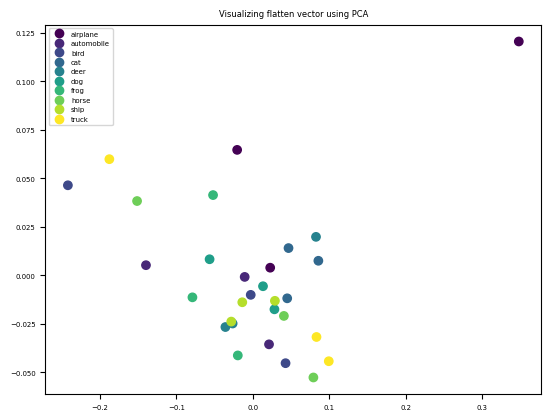

In [24]:

X = np.zeros((30, 8))
Y = np.zeros((30))
ind = rng.integers(low=0, high=4998, size=1)

for c in range(10):
    j = class_wise_labels[c, ind[0]]
    for i in range(j, j+3):
        input = inputs[i]
        output,fv = cnn.feed_forward(input= input, num_outputs= 10)
        X[3*c+i-j, :] = fv.reshape(8,)
        Y[3*c+i-j] = c
    

from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=Y)
plt.legend(handles=plot.legend_elements()[0], labels= LABELS)
plt.title("Visualizing flatten vector using PCA")
plt.show()

The above visualization shows that the randomly intitalized networks does not differentiate images depending upon the input. Instead all the outputs are closer together. 